Problem:

The UK Support Call Centre is experiencing performance issues. You are given the following datasets:
    1. An extract from our call centre software, which shows call activity
    2. UK appointment volumes
    
There are two initial hypotheses that they would like you to tesT:
    Hypothesis 1: Call centre performance has decreases over the period: 1 Feb 19 - 27 Apr 19
    Hypothesis 2: The change in call centre performance is due to poor agent performance 

In [1]:
import pandas as pd
import numpy as np
from datetime import time
from datetime import date
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn import datasets

In [3]:
# Dataset 1: Call centre data
df_1 = pd.read_excel(PATH, sheet_name=0)
# Dataset 2: UK appointments data
df_2 = pd.read_excel(PATH, sheet_name=1)

In [4]:
print(len(df_1))
df_1.head()

97873


,Period,Type,Create time,Direction,Accept time,Total time processing transaction,Total time on post processing,Abandon time,IVR Treatment Time,Tagged category
0,2019-03-29,Call,2019-03-29 16:45:37,outbound,2019-03-29 16:45:37,NaN,NaN,NaT,NaN,NaN
1,2019-03-29,Call,2019-03-29 15:22:13,outbound,2019-03-29 15:22:13,00:00:19,NaN,NaT,NaN,NaN
2,2019-03-29,Call,2019-03-29 09:16:10,outbound,2019-03-29 09:16:10,00:01:02,NaN,NaT,NaN,NaN
3,2019-03-29,Call,2019-03-29 15:42:41,outbound,2019-03-29 15:42:41,00:00:27,NaN,NaT,NaN,NaN
4,2019-03-29,Call,2019-03-29 11:54:56,outbound,2019-03-29 11:54:56,NaN,NaN,NaT,NaN,NaN


In [5]:
# Converting time data to 3 separate columns

type("Period")

str

In [6]:
print(df_1["Period"].dt.year.unique())
# All in 2019 - focus on extracting month and day 

[2019]


In [7]:
# Generating Month and Day columns

df_1["Period_Month"] = df_1["Period"].dt.month
df_1["Period_Day"] = df_1["Period"].dt.day

In [8]:
# Period to look at is 01/02/19 to 27/04/19
# Checking for any observations outside this range

print(df_1["Period_Month"].unique())

[3 4 2 1]


In [9]:
# Checking how many dates before 01/02

len(df_1[df_1["Period_Month"] == 1])
# Excude calls made in Jan 

2008

In [10]:
# Checking how many dates after 27/04

len(df_1[(df_1["Period_Month"] == 4) & (df_1["Period_Day"] > 27)])

0

In [11]:
# 2008 observations before 01/02
# Filter these out 

In [12]:
# Count number of abandoned calls
# Call is abandoned if there is a timestamp (i.e. not missing)

# Checking for impossible observations
print(len(df_1[~(df_1["Abandon time"].isnull()) & (~df_1["Total time on post processing"].isnull())]))
# Shouldn't have an adondonment timestamp and a value for processing transaction 
print(len(df_1[~(df_1["Abandon time"].isnull()) & (~df_1["Total time processing transaction"].isnull())]))
# Shouldn't have an adondonment timestamp and a timestampe for accepted time
print(len(df_1[~(df_1["Abandon time"].isnull()) & (~df_1["Accept time"].isnull())]))
# Total number of abandoned calls = 30844
print(len(df_1[~(df_1["Abandon time"].isnull())]))

# Total number of abandoned calls for the time period being analysed
print(len((df_1[~(df_1["Abandon time"].isnull()) & (df_1["Period_Month"]>1)])))

0
0
0
30844
30418


In [13]:
# Count number of accepted calls
# Call is accepted if there is a timestamp (i.e. not missing)

print(len(df_1[~(df_1["Accept time"].isnull())]))

# Total number of accepted calls for the time period being analused
print(len(df_1[~(df_1["Accept time"].isnull()) & (df_1["Period_Month"]>1)]))


# 2 calls that clearly happened but no Accept time stamp
df_1[(df_1["Accept time"].isnull()) & ((~df_1["Total time processing transaction"].isnull()) | (~df_1["Total time on post processing"].isnull()))]

52245
50968


,Period,Type,Create time,Direction,Accept time,Total time processing transaction,Total time on post processing,Abandon time,IVR Treatment Time,Tagged category,Period_Month,Period_Day
89741,2019-04-09,Call,NaT,inbound,NaN,00:02:06,00:02:25,NaT,00:00:04,Provider > Prescription > Not delivered to pha...,4,9
91425,2019-04-13,Call,NaT,inbound,NaN,00:01:58,00:03:06,NaT,00:00:19,Patient > Appointments > Book F2F Appointment,4,13


In [14]:
# Count the number of NEITHER abandoned NOR accepted
# This is whereby the user disconnected before the caller reached the call queue

print(len(df_1[(df_1["Accept time"].isnull()) & (df_1["Abandon time"].isnull())]))
df_1[(df_1["Accept time"].isnull()) & (df_1["Abandon time"].isnull())]

# Count the number of NEITHER abandoned NOR accepted in the time period being analysed
print(len(df_1[(df_1["Accept time"].isnull()) & (df_1["Abandon time"].isnull()) & (df_1["Period_Month"]>1)]))

14784
14479


In [15]:
# Define key call centre performance metric: % Abandonment Rate
# Defined as: Abandoned calls/(Abandoned calls + accepted calls)
# Target: 10% max abandoment

# Generate binary column to denote whether call was abandoned

df_1["Abandon"] = (~(df_1["Abandon time"].isnull())).astype(int)

# Generate binary column to denote whether call was accepted

df_1["Accept"] = (~(df_1["Accept time"].isnull())).astype(int)

In [16]:
# Create dataframe with Period from only 01/02
# Convert Period to days since 01/01/2019 (Since all observations are in January)
df_1['Period_int'] = df_1['Period'].dt.strftime('%j').astype(int)

filtered_time = df_1[(df_1['Period_int'] > 31)]
filtered_time

,Period,Type,Create time,Direction,Accept time,Total time processing transaction,Total time on post processing,Abandon time,IVR Treatment Time,Tagged category,Period_Month,Period_Day,Abandon,Accept,Period_int
0,2019-03-29,Call,2019-03-29 16:45:37,outbound,2019-03-29 16:45:37,NaN,NaN,NaT,NaN,NaN,3,29,0,1,88
1,2019-03-29,Call,2019-03-29 15:22:13,outbound,2019-03-29 15:22:13,00:00:19,NaN,NaT,NaN,NaN,3,29,0,1,88
2,2019-03-29,Call,2019-03-29 09:16:10,outbound,2019-03-29 09:16:10,00:01:02,NaN,NaT,NaN,NaN,3,29,0,1,88
3,2019-03-29,Call,2019-03-29 15:42:41,outbound,2019-03-29 15:42:41,00:00:27,NaN,NaT,NaN,NaN,3,29,0,1,88
4,2019-03-29,Call,2019-03-29 11:54:56,outbound,2019-03-29 11:54:56,NaN,NaN,NaT,NaN,NaN,3,29,0,1,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97868,2019-04-27,Call,2019-04-27 03:40:33,inbound,NaN,NaN,NaN,2019-04-27 03:40:45,00:00:00,NaN,4,27,1,0,117
97869,2019-04-27,Call,2019-04-27 20:42:30,inbound,NaN,NaN,NaN,2019-04-27 20:45:55,00:00:21,NaN,4,27,1,0,117
97870,2019-04-27,Call,2019-04-27 16:47:52,inbound,NaN,NaN,NaN,2019-04-27 16:52:33,00:00:00,NaN,4,27,1,0,117
97871,2019-04-27,Call,2019-04-27 11:57:10,inbound,NaN,NaN,NaN,2019-04-27 11:58:20,00:00:00,NaN,4,27,1,0,117


In [17]:
# Creating a new data frame to average abandonment rates grouped by day

grouped_rate = filtered_time[["Period","Abandon", "Accept"]].groupby(['Period']).sum()
grouped_rate['Abandon_rate'] = grouped_rate['Abandon'] / (grouped_rate['Accept'] + grouped_rate['Abandon'])
grouped_rate

,Abandon,Accept,Abandon_rate
Period,,,
2019-02-01,271,828,0.246588
2019-02-02,248,741,0.250758
2019-02-03,253,862,0.226906
2019-02-04,256,743,0.256256
2019-02-05,206,641,0.243211
...,...,...,...
2019-04-23,582,799,0.421434
2019-04-24,232,383,0.377236
2019-04-25,163,244,0.400491


In [18]:
# Want a confidence interval for this proportion
def two_proportions_confint(success_a, size_a, success_b, size_b, significance = 0.05):
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
    se = np.sqrt(var)

    # z critical value
    confidence = 1 - significance
    z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)

    # standard formula for the confidence interval
    # point-estimtate +- z * standard-error
    prop_diff = prop_b - prop_a
    confint = prop_diff + np.array([-1, 1]) * z * se
    return prop_diff, confint

success_a = 30418
size_a = 95865
success_b = 9587
size_b = 95865

two_proportions_confint(success_a, size_a, success_b, size_b)

(-0.2172951546445522, array([-0.22080043, -0.21378988]))

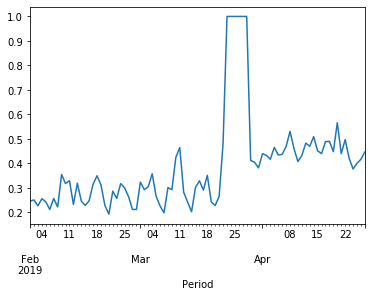

In [19]:
grouped_rate['Abandon_rate'].plot()
plt.show()

In [20]:
# Creating a new dataframe to count the number of created, accepts and abandoned calls

timeline = filtered_time[["Period","Create time", "Accept time" , "Abandon time"]].groupby(['Period']).count()
timeline

,Create time,Accept time,Abandon time
Period,,,
2019-02-01,1318,828,271
2019-02-02,1166,741,248
2019-02-03,1314,862,253
2019-02-04,1161,743,256
2019-02-05,994,641,206
...,...,...,...
2019-04-23,1523,799,582
2019-04-24,693,383,232
2019-04-25,458,244,163


In [21]:
# Looking at which period there were no accepted called

timeline[timeline['Accept time'] == 0]

# No calls accepted between 23/03 - 28/03

,Create time,Accept time,Abandon time
Period,,,
2019-03-23,447,0,229
2019-03-24,403,0,182
2019-03-25,418,0,192
2019-03-26,357,0,146
2019-03-27,161,0,70
2019-03-28,115,0,52


In [22]:
# Checking the direction of calls during the period where there were no accepted called

noaccept = df_1[(df_1['Period_Month'] == 3) & (df_1['Period_Day'] >22) & (df_1['Period_Day']<29)]
noaccept1 = noaccept[['Period' , 'Direction']].groupby(['Period' , 'Direction']).size()
noaccept1

# All calls were inbound (i.e. calls dialed by patients)

Period      Direction
2019-03-23  inbound      447
2019-03-24  inbound      403
2019-03-25  inbound      418
2019-03-26  inbound      357
2019-03-27  inbound      161
2019-03-28  inbound      115
dtype: int64

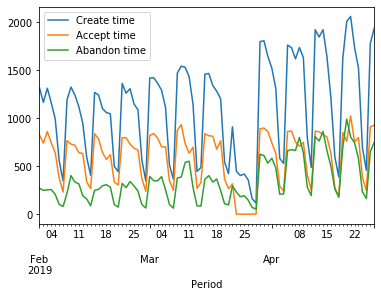

In [23]:
timeline.plot()
plt.show()

In [24]:
# Exploring whether there as been a significant change in abandonment rate
# Fit a linear regression model with and without the period with no calls

reg_full = filtered_time[['Period_int' , 'Abandon' , 'Accept']].groupby(['Period_int']).sum()
reg_full['Abandon_rate'] = reg_full['Abandon'] / (reg_full['Accept'] + reg_full['Abandon'])
reg_full

,Abandon,Accept,Abandon_rate
Period_int,,,
32,271,828,0.246588
33,248,741,0.250758
34,253,862,0.226906
35,256,743,0.256256
36,206,641,0.243211
...,...,...,...
113,582,799,0.421434
114,232,383,0.377236
115,163,244,0.400491


In [25]:
# Did the abandonment rate ever reach the targer?

reg_full[reg_full['Abandon_rate'] < 0.20]

,Abandon,Accept,Abandon_rate
Period_int,,,
52,73,305,0.193122
66,62,250,0.198718


In [26]:
reg_full = reg_full.reset_index()

In [27]:
model = linear_model.LinearRegression().fit(reg_full[['Period_int']], reg_full['Abandon_rate'])

p1 = model.predict(reg_full[['Period_int']])
print(p1)

[0.23197234 0.23570434 0.23943634 0.24316835 0.24690035 0.25063235
 0.25436436 0.25809636 0.26182836 0.26556037 0.26929237 0.27302437
 0.27675638 0.28048838 0.28422039 0.28795239 0.29168439 0.2954164
 0.2991484  0.3028804  0.30661241 0.31034441 0.31407641 0.31780842
 0.32154042 0.32527243 0.32900443 0.33273643 0.33646844 0.34020044
 0.34393244 0.34766445 0.35139645 0.35512845 0.35886046 0.36259246
 0.36632446 0.37005647 0.37378847 0.37752048 0.38125248 0.38498448
 0.38871649 0.39244849 0.39618049 0.3999125  0.4036445  0.4073765
 0.41110851 0.41484051 0.41857251 0.42230452 0.42603652 0.42976853
 0.43350053 0.43723253 0.44096454 0.44469654 0.44842854 0.45216055
 0.45589255 0.45962455 0.46335656 0.46708856 0.47082057 0.47455257
 0.47828457 0.48201658 0.48574858 0.48948058 0.49321259 0.49694459
 0.50067659 0.5044086  0.5081406  0.5118726  0.51560461 0.51933661
 0.52306862 0.52680062 0.53053262 0.53426463 0.53799663 0.54172863
 0.54546064 0.54919264]


In [28]:
from scipy import stats

In [29]:
y1 = reg_full['Abandon_rate'].to_numpy()

In [30]:
stats.ttest_ind(p1, y1)

Ttest_indResult(statistic=-4.803383327258978e-15, pvalue=0.9999999999999962)

In [31]:
# The coefficients
print('Coefficients: \n', model.coef_)
print('Intercept: \n', model.intercept_)

Coefficients: 
 [0.003732]
Intercept: 
 0.11254822035839845


In [32]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(reg_full['Abandon_rate'], p1))

Mean squared error: 0.03


In [33]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(reg_full['Abandon_rate'], p1))

Coefficient of determination: 0.23


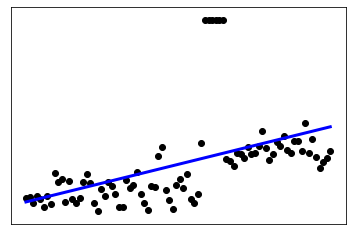

In [34]:
# Plot outputs
plt.scatter(reg_full[['Period_int']], reg_full['Abandon_rate'],  color='black')
plt.plot(reg_full[['Period_int']], p1, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [35]:
# Create dataframe with Period from 01/02 without randonment rates = 1

reg = filtered_time[['Period_int' , 'Period_Month' , 'Period_Day' , 'Abandon' , 'Accept']].groupby(['Period_int' , 'Period_Month' , 'Period_Day']).sum()
reg['Abandon_rate'] = reg['Abandon'] / (reg['Accept'] + reg['Abandon'])

In [36]:
reg = reg.reset_index()

In [37]:
reg2 = reg[((reg['Period_int'] < 82) | (reg['Period_int'] > 87))]
reg2

,Period_int,Period_Month,Period_Day,Abandon,Accept,Abandon_rate
0,32,2,1,271,828,0.246588
1,33,2,2,248,741,0.250758
2,34,2,3,253,862,0.226906
3,35,2,4,256,743,0.256256
4,36,2,5,206,641,0.243211
...,...,...,...,...,...,...
81,113,4,23,582,799,0.421434
82,114,4,24,232,383,0.377236
83,115,4,25,163,244,0.400491
84,116,4,26,652,911,0.417147


In [38]:
# Looking at any abandonment rates = 1

reg2[reg2['Abandon_rate'] == 1.00]

,Period_int,Period_Month,Period_Day,Abandon,Accept,Abandon_rate


In [39]:
model2 = linear_model.LinearRegression().fit(reg2[['Period_int']], reg2['Abandon_rate'])

p2 = model2.predict(reg2[['Period_int']])
print(p2)

[0.21844995 0.22147813 0.2245063  0.22753447 0.23056265 0.23359082
 0.23661899 0.23964716 0.24267534 0.24570351 0.24873168 0.25175986
 0.25478803 0.2578162  0.26084438 0.26387255 0.26690072 0.26992889
 0.27295707 0.27598524 0.27901341 0.28204159 0.28506976 0.28809793
 0.2911261  0.29415428 0.29718245 0.30021062 0.3032388  0.30626697
 0.30929514 0.31232332 0.31535149 0.31837966 0.32140783 0.32443601
 0.32746418 0.33049235 0.33352053 0.3365487  0.33957687 0.34260504
 0.34563322 0.34866139 0.35168956 0.35471774 0.35774591 0.36077408
 0.36380226 0.36683043 0.38802764 0.39105581 0.39408398 0.39711216
 0.40014033 0.4031685  0.40619668 0.40922485 0.41225302 0.4152812
 0.41830937 0.42133754 0.42436571 0.42739389 0.43042206 0.43345023
 0.43647841 0.43950658 0.44253475 0.44556292 0.4485911  0.45161927
 0.45464744 0.45767562 0.46070379 0.46373196 0.46676014 0.46978831
 0.47281648 0.47584465]


In [40]:
y2 = reg2['Abandon_rate'].to_numpy()

In [41]:
stats.ttest_ind(p2, y2)

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [42]:
# The coefficients

print('Coefficients: \n', model2.coef_[0])
print('Intercept: \n', model2.intercept_)

Coefficients: 
 0.003028172941337307
Intercept: 
 0.1215484201973217


In [43]:
# The mean squared error

print('Mean squared error: %.2f'
      % mean_squared_error(reg2['Abandon_rate'], p2))

Mean squared error: 0.00


In [44]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(reg2['Abandon_rate'], p2))

Coefficient of determination: 0.62


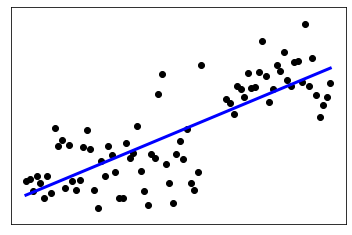

In [45]:
# Plot outputs
plt.scatter(reg2[['Period_int']], reg2['Abandon_rate'],  color='black')
plt.plot(reg2[['Period_int']], p2, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [46]:
# # # # # # # # # # # # # # # # # # # 
# Now analysing sheet 2

df_2

,appt_date,modality,medium,consultant_type,state,count_appts
0,2019-04-25,digital,voice,GP,no_show,3
1,2019-04-25,digital,video,GP,no_show,12
2,2019-04-25,digital,video,GP,completed,178
3,2019-04-25,digital,voice,GP,cancelled,52
4,2019-04-25,digital,video,GP,paid,2
...,...,...,...,...,...,...
3125,2019-02-01,digital,voice,GP,cancelled,0
3126,2019-02-01,digital,voice,Therapist,cancelled,3
3127,2019-02-01,digital,video,Therapist,timed_out,0
3128,2019-02-01,digital,video,GP,timed_out,18


In [47]:
print(df_2["appt_date"].dt.year.unique())
# All in 2019 - focus on extracting month and day 

[2019]


In [48]:
# Generating Month and Day columns

df_2["appt_month"] = df_2["appt_date"].dt.month
df_2["appt_day"] = df_2["appt_date"].dt.day

In [49]:
# Period to look at is 01/02/19 to 27/04/19
# Checking for any observations outside this range

print(df_2["appt_month"].unique())

# All appointments in the analysis period - good 

[4 3 2]


In [50]:
# Create data frame

summ_appt = df_2[["appt_date" , "state" , "count_appts"]].groupby(["appt_date" , "state"]).sum()
summ_appt = summ_appt.reset_index()

In [51]:
summ_appt

,appt_date,state,count_appts
0,2019-02-01,cancelled,256
1,2019-02-01,completed,999
2,2019-02-01,no_show,67
3,2019-02-01,paid,0
4,2019-02-01,timed_out,23
...,...,...,...
409,2019-04-25,cancelled,140
410,2019-04-25,completed,482
411,2019-04-25,no_show,39
412,2019-04-25,paid,2


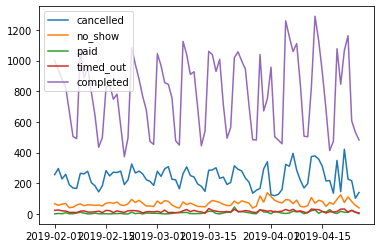

In [52]:
plt.plot(summ_appt[summ_appt['state']=="cancelled"]["appt_date"] , summ_appt[summ_appt['state']=="cancelled"]["count_appts"], label='cancelled')
plt.plot(summ_appt[summ_appt['state']=="no_show"]["appt_date"] , summ_appt[summ_appt['state']=="no_show"]["count_appts"], label='no_show')
plt.plot(summ_appt[summ_appt['state']=="paid"]["appt_date"] , summ_appt[summ_appt['state']=="paid"]["count_appts"], label='paid')
plt.plot(summ_appt[summ_appt['state']=="timed_out"]["appt_date"] , summ_appt[summ_appt['state']=="timed_out"]["count_appts"], label='timed_out')
plt.plot(summ_appt[summ_appt['state']=="completed"]["appt_date"] , summ_appt[summ_appt['state']=="completed"]["count_appts"], label='completed')

plt.legend()
plt.show()

In [53]:
df_1['Post'] = pd.to_timedelta(df_1['Total time on post processing'].astype(str), unit='s')
df_1['Post'] = df_1['Post'].dt.seconds
df_1

,Period,Type,Create time,Direction,Accept time,Total time processing transaction,Total time on post processing,Abandon time,IVR Treatment Time,Tagged category,Period_Month,Period_Day,Abandon,Accept,Period_int,Post
0,2019-03-29,Call,2019-03-29 16:45:37,outbound,2019-03-29 16:45:37,NaN,NaN,NaT,NaN,NaN,3,29,0,1,88,NaN
1,2019-03-29,Call,2019-03-29 15:22:13,outbound,2019-03-29 15:22:13,00:00:19,NaN,NaT,NaN,NaN,3,29,0,1,88,NaN
2,2019-03-29,Call,2019-03-29 09:16:10,outbound,2019-03-29 09:16:10,00:01:02,NaN,NaT,NaN,NaN,3,29,0,1,88,NaN
3,2019-03-29,Call,2019-03-29 15:42:41,outbound,2019-03-29 15:42:41,00:00:27,NaN,NaT,NaN,NaN,3,29,0,1,88,NaN
4,2019-03-29,Call,2019-03-29 11:54:56,outbound,2019-03-29 11:54:56,NaN,NaN,NaT,NaN,NaN,3,29,0,1,88,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97868,2019-04-27,Call,2019-04-27 03:40:33,inbound,NaN,NaN,NaN,2019-04-27 03:40:45,00:00:00,NaN,4,27,1,0,117,NaN
97869,2019-04-27,Call,2019-04-27 20:42:30,inbound,NaN,NaN,NaN,2019-04-27 20:45:55,00:00:21,NaN,4,27,1,0,117,NaN
97870,2019-04-27,Call,2019-04-27 16:47:52,inbound,NaN,NaN,NaN,2019-04-27 16:52:33,00:00:00,NaN,4,27,1,0,117,NaN
97871,2019-04-27,Call,2019-04-27 11:57:10,inbound,NaN,NaN,NaN,2019-04-27 11:58:20,00:00:00,NaN,4,27,1,0,117,NaN


In [54]:
df_3 = df_1[["Period_int" , "Post"]].groupby(["Period_int"]).mean()
df_3

,Post
Period_int,
29,32.320532
30,51.132964
31,50.489540
32,43.682367
33,42.983806
...,...
113,59.069465
114,75.980000
115,62.431925


In [55]:
df_3 = df_3[~df_3['Post'].isnull()]
df_3

,Post
Period_int,
29,32.320532
30,51.132964
31,50.489540
32,43.682367
33,42.983806
...,...
113,59.069465
114,75.980000
115,62.431925


In [56]:
df_3 = df_3.reset_index()

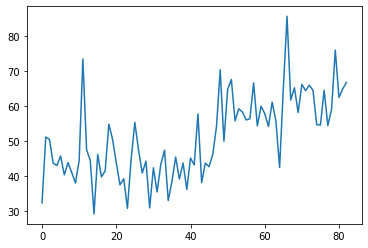

In [57]:
df_3['Post'].plot()
plt.show()

In [58]:
# linear regression to show increase in post admin over time 

model3 = linear_model.LinearRegression().fit(df_3[['Period_int']], df_3['Post'])

p3 = model3.predict(df_3[['Period_int']])
print(p3)

[38.34630218 38.64015631 38.93401044 39.22786457 39.5217187  39.81557283
 40.10942696 40.40328109 40.69713522 40.99098935 41.28484348 41.57869761
 41.87255174 42.16640587 42.46026    42.75411413 43.04796826 43.34182239
 43.63567652 43.92953065 44.22338478 44.51723891 44.81109304 45.10494717
 45.3988013  45.69265543 45.98650956 46.28036369 46.57421782 46.86807195
 47.16192608 47.45578021 47.74963434 48.04348847 48.33734259 48.63119672
 48.92505085 49.21890498 49.51275911 49.80661324 50.10046737 50.3943215
 50.68817563 50.98202976 51.27588389 51.56973802 51.86359215 52.15744628
 52.45130041 52.74515454 53.03900867 53.3328628  53.62671693 55.68369584
 55.97754997 56.2714041  56.56525823 56.85911236 57.15296649 57.44682062
 57.74067475 58.03452888 58.32838301 58.62223714 58.91609127 59.2099454
 59.50379953 59.79765366 60.09150779 60.38536192 60.67921605 60.97307018
 61.26692431 61.56077844 61.85463257 62.1484867  62.44234083 62.73619496
 63.03004909 63.32390322 63.61775735 63.91161148 64.2

In [59]:
# The coefficients

print('Coefficients: \n', model3.coef_[0])
print('Intercept: \n', model3.intercept_)

Coefficients: 
 0.29385412983023207
Intercept: 
 29.82453241565467


In [60]:
# The mean squared error

print('Mean squared error: %.2f'
      % mean_squared_error(df_3['Post'], p3))

Mean squared error: 73.93


In [61]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(df_3['Post'], p3))

Coefficient of determination: 0.45


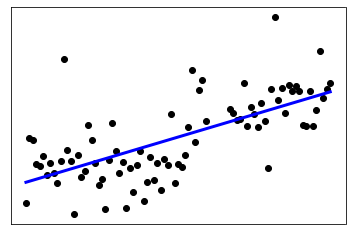

In [62]:
# Plot outputs
plt.scatter(df_3[['Period_int']], df_3['Post'],  color='black')
plt.plot(df_3[['Period_int']], p3, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()